In [ ]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.applications import VGG16, InceptionV3, InceptionResNetV2,ResNet50, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


# Plotting History

In [3]:
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.tight_layout()
    plt.show()

# Loading Data

In [4]:
def preprocess_image (image):
    # resizing to 224 by 224
    image = cv2.resize(image, (224, 224)) 
    
    # Normalizating data between 0 and 1
    image = image.astype('float32') / 255.0 
    
    return image

In [5]:
def load_images(dir_path):
    images = []
    for filename in os.listdir(dir_path):
        if filename.endswith('.jpeg'):  
            image_path = os.path.join(dir_path, filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
            image = preprocess_image(image)
            images.append(image)
            
    return np.array(images)


# ResNet50 Model Definition

In [8]:
def create_resnet50_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers[:-4]:  # Fine-tune the last few layers
        layer.trainable = True

    model = Sequential()

    model.add(base_model)
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    return model

# VGG16 Model

In [9]:
def create_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers[:-4]:  # Fine-tune the last few layers
        layer.trainable = True

    model = Sequential()

    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    return model

# InceptionV3 Model

In [10]:
def create_inceptionv3_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers[:-4]:  # Fine-tune the last few layers
        layer.trainable = True

    model = Sequential()

    model.add(base_model)
    model.add(GlobalAveragePooling2D())  # Global Average Pooling instead of Flatten
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    return model

# Inception ResNet V2

In [11]:
def create_inceptionresnetv2_model():
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers[:-4]:  # Fine-tune the last few layers
        layer.trainable = True

    model = Sequential()

    model.add(base_model)
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [39]:
def create_custom_cnn_model():
    model = Sequential()
    
    # First convolutional layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    
    # Second convolutional layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # Third convolutional layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # Flatten the output of the convolutional layers
    model.add(Flatten())
    
    # Dense layers
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    
    return model




In [6]:
def load_data ():
    normal_images = load_images('/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL')
    pneumonia_images = load_images('/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA')

    X = np.concatenate((normal_images, pneumonia_images), axis=0)
    y = np.concatenate((np.zeros(len(normal_images)), np.ones(len(pneumonia_images))))
    
    return X, y

In [7]:
def shuffle_data (X, y):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    return X, y


In [8]:
def apply_data_augmentation (X, y, batch_size):
    
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X.reshape(-1, 224 * 224 * 3), y)
    X_resampled = X_resampled.reshape(-1, 224, 224, 3)
    
    X, y = shuffle_data (X_resampled, y_resampled)
    
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        validation_split=0.2
    )
    
    train_generator = datagen.flow(X_resampled,y_resampled , batch_size=batch_size, subset='training')
    validation_generator = datagen.flow(X_resampled, y_resampled, batch_size=batch_size, subset='validation')
    
    return train_generator, validation_generator

In [9]:
X, y = load_data()
batch_size = 32
train_data , validation_data = apply_data_augmentation (X, y, batch_size = batch_size)

In [14]:
print("X shape: ", X.shape)
print("Y shape: ", y.shape)
print("Train generator shape: ", train_data.n)
print("Valuidation generator shape: ", validation_data.n)
print("Total: ", train_data.n +  validation_data.n)

X shape:  (5216, 224, 224, 3)
Y shape:  (5216,)
Train generator shape:  6200
Valuidation generator shape:  1550
Total:  7750


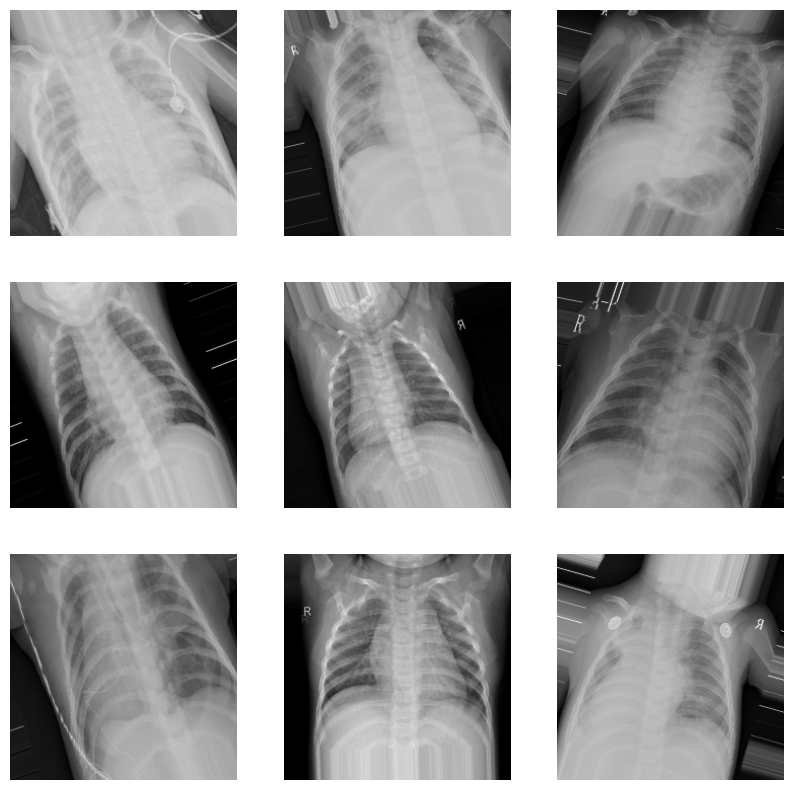

In [15]:
# Get one batch of augmented samples from the generator
augmented_samples, _ = next(train_data)

# Plotting a few augmented samples
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_samples[i].astype('float64'))  # Convert to uint8 for display
    plt.axis('off')
plt.show()

# EfficientNetB7

In [34]:
def create_efficientnetb3_model():
    base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers[:-4]:  # Fine-tune the last few layers
        layer.trainable = True

    model = Sequential()

    model.add(base_model)
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
device = tf.config.list_physical_devices('GPU')
if device:
    print('GPU:', device[0])
    
    model = create_efficientnetb3_model()
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    model.summary();

    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = callbacks.LearningRateScheduler(lambda epoch: 1e-3 * (0.9 ** epoch)) 
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)
    
    epochs = 50
    
    history = model.fit(train_data, epochs=epochs, batch_size=batch_size, validation_data=validation_data, callbacks=[early_stopping, lr_scheduler, reduce_lr])
    plot_history(history)
    
    evaluation = model.evaluate(validation_data)
    print("Loss:", evaluation[0], " Accuracy: ", evaluation[1])
else:
    print("No GPU available.")

GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ ?                      │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 10,696,232 (40.80 MB)

 Non-trainable params: 87,303 (341.03 KB)

Epoch 1/50
 98/194 ━━━━━━━━━━━━━━━━━━━━ 42s 441ms/step - accuracy: 0.8805 - loss: 0.2720

In [31]:
# dir_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL'
dir_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA'

normal_predicted = 0
pneumonia_predicted = 0

for filename in os.listdir(dir_path):
    if filename.endswith('.jpeg'):  
        image_path = os.path.join(dir_path, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        image = cv2.resize(image, (224, 224)) 
        image = image.astype('float32') / 255.0
        image = image.reshape(1,224,224,3)
        pred = model.predict(image)[0][0] 
        
        if pred > 0.5:
            pneumonia_predicted += 1
        else:
            normal_predicted += 1
            
        
            
print("Normal: ", normal_predicted)
print("Pnemunia: ", pneumonia_predicted)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_409 (Conv2D)             │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_410 (Conv2D)             │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_411 (Conv2D)             │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,527,681 (169.86 MB)

 Trainable params: 44,527,681 (169.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.7219 - loss: 0.6341

2024-04-27 11:52:50.529405: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147863: 4.72744, expected 4.0417
2024-04-27 11:52:50.529460: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147880: 5.73293, expected 5.0472
2024-04-27 11:52:50.529475: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147890: 5.71297, expected 5.02723
2024-04-27 11:52:50.529484: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147914: 5.62853, expected 4.94279
2024-04-27 11:52:50.529492: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147917: 5.73317, expected 5.04744
2024-04-27 11:52:50.529501: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147918: 5.66365, expected 4.97791
2024-04-27 11:52:50.529509: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147919: 5.64485, expected 4.95912
2024-04-27 11:52:50.52

131/131 ━━━━━━━━━━━━━━━━━━━━ 74s 506ms/step - accuracy: 0.7226 - loss: 0.6338 - val_accuracy: 0.7776 - val_loss: 18.9238 - learning_rate: 0.0010
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 63s 463ms/step - accuracy: 0.8209 - loss: 5.3256 - val_accuracy: 0.8974 - val_loss: 8.2897 - learning_rate: 9.0000e-04
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 63s 461ms/step - accuracy: 0.8706 - loss: 0.9075 - val_accuracy: 0.8802 - val_loss: 2.4572 - learning_rate: 8.1000e-04
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 63s 464ms/step - accuracy: 0.8872 - loss: 0.3361 - val_accuracy: 0.8888 - val_loss: 1.4331 - learning_rate: 7.2900e-04
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 63s 460ms/step - accuracy: 0.8941 - loss: 0.2854 - val_accuracy: 0.8897 - val_loss: 0.8618 - learning_rate: 6.5610e-04
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 63s 462ms/step - accuracy: 0.8890 - loss: 0.8080 - val_accuracy: 0.8945 - val_loss: 2.4148 - learning_rate: 5.9049e-04
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 63s 463ms/step - acc

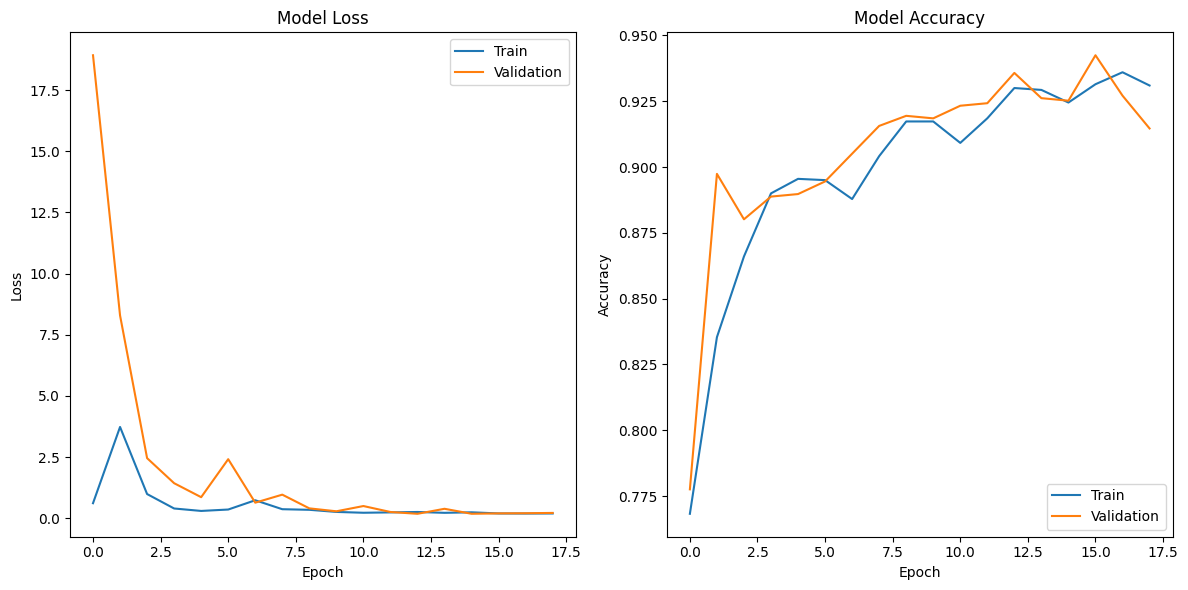

33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 378ms/step - accuracy: 0.9193 - loss: 0.1932
Loss: 0.1936223953962326  Accuracy:  0.9309683442115784


In [41]:
device = tf.config.list_physical_devices('GPU')
if device:
    print('GPU:', device[0])
    # Create the custom CNN model
    model = create_custom_cnn_model()
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    model.summary();

    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = callbacks.LearningRateScheduler(lambda epoch: 1e-3 * (0.9 ** epoch)) 
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)
    
    
    
    epochs = 50
    
    history = model.fit(train_data, epochs=epochs, batch_size=batch_size, validation_data=validation_data, callbacks=[early_stopping, lr_scheduler, reduce_lr])
    plot_history(history)
    
    evaluation = model.evaluate(validation_data)
    print("Loss:", evaluation[0], " Accuracy: ", evaluation[1])
else:
    print("No GPU available.")

In [44]:
dir_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL'
# dir_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA'

normal_predicted = 0
pneumonia_predicted = 0

for filename in os.listdir(dir_path):
    if filename.endswith('.jpeg'):  
        image_path = os.path.join(dir_path, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        image = cv2.resize(image, (224, 224)) 
        image = image.astype('float32') / 255.0
        image = image.reshape(1,224,224,3)
        pred = model.predict(image)[0][0] 
        
        if pred > 0.5:
            pneumonia_predicted += 1
        else:
            normal_predicted += 1
            
        
            
print("Normal: ", normal_predicted)
print("Pnemunia: ", pneumonia_predicted)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━